In [1]:
import pandas as pd
import pickle as pkl

import torch,ipdb
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data
import numpy as np
import platform
import time
import matplotlib.pyplot as plt
from torcheval.metrics import R2Score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [2]:
print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"
print(f"PyTorch Version: {torch.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-13.3.1-arm64-arm-64bit
PyTorch Version: 1.13.1
PyTorch Version: 1.13.1
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


In [4]:
path = '/Users/svennomm/kohalikTree/Data/AIRSCS/wave/data_v2/alternative_processing/katse_09/'

with open(path + 'katse_09_winx_384_ldn_train.pkl', 'rb') as f:
    data_1 = pkl.load(f)

initial_data_train = data_1[0]
initial_data_valid = data_1[1]
target_data_train = data_1[2]
target_data_valid = data_1[3]
valid_index = data_1[4]

with open(path + 'katse_09_winx_384_ldn_test.pkl', 'rb') as f:
    data_1 = pkl.load(f)


input_data_test = data_1[0]
target_data_test = data_1[1]
test_data_indexes = data_1[2]

X_train = initial_data_train
y_train = target_data_train

X_test = initial_data_valid
y_test = target_data_valid

X_valid = input_data_test
y_valid = target_data_test

In [5]:
def remove_nan_rows(X, y):
    print(np.isnan(X).any())
    if np.isnan(X).any():
        locations = np.argwhere(np.isnan(X))
        rows = []
        for location in locations:
            if location[0]  not in rows:
                rows.append(location[0])

        X = np.delete(X, rows, axis=0)
        y = np.delete(y, rows, axis=0)
    return X, y

X_train, y_train = remove_nan_rows(X_train, y_train)
X_test, y_test = remove_nan_rows(X_test, y_test)
print("Presence of nan rows in X_train and y_train ", np.isnan(X_train).any(), np.isnan(y_train).any())
print("Presence of nan rows in X_test and y_test ", np.isnan(X_test).any(), np.isnan(y_test).any())

False
True
Presence of nan rows in X_train and y_train  False False
Presence of nan rows in X_test and y_test  False False


In [48]:
print(type(X_train[3, 5]))

<class 'numpy.float32'>


In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size = 0.7, test_size=0.3)

print("training data sets ", X_train.shape, type(X_train), y_train.shape, type(y_train))
print("validation data sets ", X_valid.shape,type(X_valid),y_valid.shape, type(y_valid))
print("testing data sets ", X_test.shape,type(X_test), y_test.shape, type(y_test))

training data sets  (3827, 103) <class 'numpy.ndarray'> (3827, 103) <class 'numpy.ndarray'>
validation data sets  (1641, 103) <class 'numpy.ndarray'> (1641, 103) <class 'numpy.ndarray'>
testing data sets  (50, 103) <class 'numpy.ndarray'> (50, 103) <class 'numpy.ndarray'>


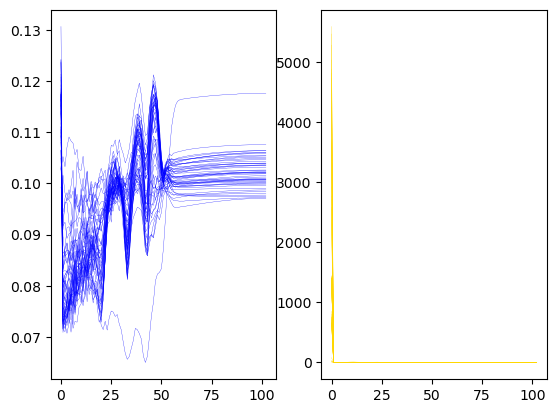

In [7]:
n = len(X_test)
fig_1 = plt.figure()
ax_1_1 = fig_1.add_subplot(1, 2, 1)
ax_1_2 = fig_1.add_subplot(1, 2, 2)




for i in range(0, n):
    #if i % 100 != 0:
    ax_1_1.plot(X_test[i, :], color='blue', linewidth=0.2)
    ax_1_2.plot(y_test[i, :], color='gold', linewidth=0.2)



plt.show()

In [8]:
device = torch.device('mps')
def create_dataset(X_train, y_train):
    X, y = [], []
    nx, mx = X_train.shape
    ny, my = y_train.shape
    for i in range(0, nx):
        ax = np.transpose(X_train[i,:]).reshape([mx, 1])
        ay = np.transpose(y_train[i, :]).reshape([my, 1])
        X.append(ax)
        y.append(ay)

    X = np.asarray(X)
    y = np.asarray(y)
    return torch.tensor(X).float(), torch.tensor(y).float()

In [9]:
X_train, y_train = create_dataset(X_train, y_train)
X_test, y_test = create_dataset(X_test, y_test)
X_valid, y_valid = create_dataset(X_valid, y_valid)

X_train, y_train = X_train.to('mps'), y_train.to('mps')
X_test, y_test = X_test.to('mps'), y_test.to('mps')
X_valid, y_valid = X_valid.to('mps'), y_valid.to('mps')

In [10]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=16, num_layers=3, batch_first=True)
        #self.norm1 = torch.nn.LayerNorm([1, 16,16,1])
        #self.lstm_1 = nn.LSTM(32, 32, 1)
        #self.lstm_2 = nn.LSTM(8, 8, 1)
        #self.lstm_3 = nn.LSTM(8, 8, 1)
        #self.lstm_4 = nn.LSTM(8, 8, 1)
        self.linear = nn.Linear(16, 1)


    def forward(self, x):
        x, _ = self.lstm(x)
        #x, _ = self.norm1(x)
        #x, _ = self.lstm_1(x)
        #x, _ = self.lstm_2(x)
        #x, _ = self.lstm_3(x)
        #x, _ = self.lstm_4(x)
        x = self.linear(x)
        return x

In [11]:
model = AirModel()
model.to('mps')
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = nn.MSELoss()
print(type(X_train), torch.Tensor.size(X_train), type(y_train), torch.Tensor.size(y_train))
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=200)
metric = R2Score()

rmse_train = []
rmse_test = []

<class 'torch.Tensor'> torch.Size([3827, 103, 1]) <class 'torch.Tensor'> torch.Size([3827, 103, 1])
